<a href="https://colab.research.google.com/github/leegahyeon09/Travel_Trend_Analysis/blob/main/travel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 여행 빅데이터 분석 보고서 (2018–2024)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import re
import matplotlib as mpl
import shutil
!apt-get install -y fonts-nanum

shutil.rmtree(mpl.get_cachedir(), ignore_errors=True)

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)

sns.set_theme(font="NanumGothic", rc={"font.family": "NanumGothic"})

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
print("적용된 폰트:", plt.rcParams['font.family'])


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
적용된 폰트: ['NanumGothic']


# 1. 프로젝트 개요

본 프로젝트는 2018년부터 2024년까지의 국내·해외 여행 관련 공공 데이터 및 플랫폼 검색량 데이터를 통합 분석하여,

*  여행 트렌드 변화
*  코로나19 전·중·후 관심도 변화
*  성별·연령·여행유형별 여행 패턴
*  지역별 관심도 구조 및 군집화
*  추천 시스템 구축
*  2025년 관심도 예측

을 수행하는 것을 목표로 한다.

본 프로젝트에서 사용한 데이터는 다음 5개 그룹으로 구성된다.

① 네이버 데이터랩 – 여행 키워드 기반 검색량

국내여행 검색량

해외여행 검색량

② 네이버 데이터랩 – 관광 테마 기반 관심도

도시관광 (2종)

자연휴양 (2종)

가족레저 (1종)

※ 이 3개는 모두 “관광 테마(도시/자연/가족)에 대한 관심도”이며
그래프에서 함께 비교되는 동일 그룹이다.

③ Google Trends 검색량

국내여행 (domestic)

해외여행 (overseas)

④ 문화체육관광부 국민여행실태조사

국내여행 횟수 데이터
(성별/연령대/여행유형별 통계)

⑤ 한국관광공사(KTO) 관광데이터랩

국민 해외관광객 수(명)
→ 해외 출국자 월별 데이터

In [26]:
def plot_pie(title, series):
    plt.figure(figsize=(8,8))
    plt.pie(series.values, labels=series.index,
            autopct="%.1f%%", startangle=140)
    plt.title(title, fontsize=16)
    plt.show()


def plot_line(df, x, y, group, title):
    plt.figure(figsize=(13,6))
    for g in df[group].unique():
        temp = df[df[group] == g]
        plt.plot(temp[x], temp[y], marker="o", label=g)

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_region_bar(series, title):
    plt.figure(figsize=(10,12))
    plt.barh(series.index, series.values, color="#77aadd")
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=16)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.show()


#  2. 데이터 소개
**2-1. 네이버 데이터랩 – 여행 키워드 기반 검색량**

● 사용 키워드
* “국내여행”
* “해외여행”

● 주요 특징
* 네이버 검색 기반 관심도(ratio) 제공
* 날짜(date) 및 ratio만 추출
* Google Trends와 비교를 위해 keyword = domestic / overseas 부여

● 분석 활용
* 국내 vs 해외 관심도 추세 비교
* 코로나 전·중·후 관심도 변화
* 출국자수(KTO)와 상관관계 분석

**2-2. 네이버 데이터랩 – 관광 테마 기반 관심도 (도시/자연/가족)**
도시관광 2종 + 자연휴양 2종 + 가족레저 1종 총 5개 파일을 정제 후 하나의 데이터셋으로 통합

● 구성
* 도시관광: datalab_도시관광.xlsx, datalab_도시관광2.xlsx
* 자연휴양: datalab_자연휴양.xlsx, datalab_자연휴양2.xlsx
* 가족레저: datalab_가족레저.xlsx

● 특징
* Raw 데이터는 6~7행 이후에 유효 데이터가 시작됨
* “date”와 “ratio”만 추출
* category = 도시관광/자연휴양/가족레저 부여
* "관광 테마 기반 관심도" 비교 그래프에서 함께 활용
* 코로나 기간별 선호 테마 변화 분석 가능

**2-3. Google Trends – 검색량 데이터**

● 키워드
* domestic (국내여행)
* overseas (해외여행)

● 특징
* “YYYY-MM” 형식 → “YYYY-MM-01”로 변환
* header 제거를 위해 skiprows=2
* “-” 값은 NaN 처리 후 제거
* source = “google”, keyword 부여

● 활용
* 네이버 데이터랩과 함께 국내/해외 * 검색량 비교
* 코로나 시기별 관심도 변화
* Prophet 예측 모델 학습에 사용

** 2-4. 문화체육관광부(MCST) – 국민여행실태조사 **

● 항목 구조
* 성별 (남/여)
* 연령대 (10대후반 ~ 70대+)
* 여행유형 (8종: 숙박/당일/관광 등)

● 전처리 특징
* wide → long(melt) 변환
* 예: “2018.1” → year=2018, type=1 분리
* type_map 적용 → 의미 있는 유형 이름으로 변환
* “12,300” → “12300” 숫자 정제

● 활용
* 성별 여행량 추세
* 연령대별 여행량 변화
* 여행유형별 변화
* 연령×유형 Heatmap 분석

**2-5. 한국관광공사(KTO) – 해외출국자수**

● 구성
* 기준연월(YYYY-MM)
* 국민 해외관광객 수(명)

● 전처리
* 기준연월 → “YYYY-MM-01” 날짜 변환
* keyword = departure

● 활용
* 해외여행 관심도(Google/Naver)와 실제 출국자수 상관관계 분석
* 예측모델 타당성 검증

** 2-6. 네이버 데이터랩 – 지역 기반 관심도 **

● 구성
* 도시관광 2종
* 자연휴양 2종
* 해외여행 1종
(“부산여행”, “서울여행”, “제주도여행” 등)

● 특징
* “○○여행” 텍스트에서 지역명 자동 추출
* date + ratio 정제 후 통합
* 2025년 데이터 제거 (2018~2024 통일)

● 활용

* WordCloud
* KMeans 군집
* PCA 시각화
* Cosine Similarity 지역 추천

In [27]:


def load_datalab_keyword(path, category_name):
    df_raw = pd.read_excel(path, header=None)

    def is_date(x):
        try:
            pd.to_datetime(x, format="%Y-%m-%d")
            return True
        except:
            return False

    df = df_raw[df_raw[0].apply(is_date)].copy()
    df = df.rename(columns={0: "date", 1: "ratio"})
    df["category"] = category_name
    df["date"] = pd.to_datetime(df["date"])

    return df[["date", "ratio", "category"]]

In [28]:

def load_region_datalab(path):
    df_raw = pd.read_excel(path, header=None)
    header = df_raw.iloc[6].tolist()
    df = df_raw.iloc[7:].reset_index(drop=True)

    regions = []
    for h in header:
        if isinstance(h, str) and re.fullmatch(r"[가-힣]+여행", h.strip()):
            regions.append(h.replace("여행", "").strip())

    result = pd.DataFrame()
    col_idx = 0

    for region in regions:
        temp = pd.DataFrame()
        temp["date"] = df[col_idx]
        temp["ratio"] = df[col_idx + 1]
        temp["region"] = region

        result = pd.concat([result, temp], ignore_index=True)
        col_idx += 2

    result["date"] = pd.to_datetime(result["date"], errors="coerce")
    result["ratio"] = pd.to_numeric(result["ratio"], errors="coerce")
    result["year"] = result["date"].dt.year
    return result.dropna().reset_index(drop=True)


# 3. 데이터 전처리

본 프로젝트는 출처가 제각각인 복합 데이터를 사용하기 때문에,
데이터 표준화·정제·통합 과정이 매우 중요한 역할을 했다.

아래는 실제 코드 기반으로 수행된 전처리 전체 절차이다.

**3-1. 날짜 형식 표준화**

* YYYY-MM	-> YYYY-MM-01
* YYYY-MM-DD	-> 그대로 사용 (시계열 정렬)
→ 모든 날짜를 datetime으로 변환하여 시계열 비교 가능하게 함.

**3-2. 문자열/특수문자 정제**

* “12,300” → “12300”
* “ 64 ” → “64”
* Google Trends의 “-” 값 제거
* “부산여행” → “부산” (여행 텍스트 제거)

**3-3. 컬럼 구조 표준화 **

* 모든 데이터셋을 다음 공통 구조로 변환.

| date | value | source | keyword/category/type/sub_category |

**3-4. 범주형 값 통일**

* 연령대: “15-19”, “15-19세” → “10대후반”
* 70세 이상 → 70대+
* Type code(1~8) → 의미 있는 텍스트 레이블로 변환

**3-5. 결측치·중복 제거**

* datalab 앞부분 헤더 제거
* Trends의 “-” 값 제거
* melt 이후 발생 NaN 제거
* 도시관광/자연휴양 2종 merge 후 중복 index 정리

**3-6. 분석 기간 통일 (2018~2024)**

* 모든 데이터에서 2025년 데이터 제거
* 코로나 기간 라벨링 적용

-pre : -2019

-mid : 2020-2022.06

-post : 2022.07-

**3-7. 데이터 통합**

● 검색량 기반(df_all)
네이버 domestic/overseas + Google Trends + KTO 출국자수 통합

● 지역 기반(df_domestic_region)
도시관광·자연휴양·해외 지역 데이터를 하나로 통합

In [29]:


domestic = pd.read_excel("/content/국내여행횟수.xlsx")
domestic = domestic.iloc[1:].reset_index(drop=True)
domestic = domestic.rename(columns={"구분": "category", "세부구분": "sub_category"})

value_cols = [c for c in domestic.columns
              if any(str(c).startswith(y)
                     for y in ["2018","2019","2020","2021","2022","2023","2024"])]

df_long = domestic.melt(
    id_vars=["category","sub_category"],
    value_vars=value_cols,
    var_name="year_type",
    value_name="value"
)

df_long[["year","type"]] = (
    df_long["year_type"]
    .astype(str)
    .str.split(".", n=1, expand=True, regex=False)
)

df_long["type"] = df_long["type"].fillna("국내전체")
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year"])

type_map = {
    '1': "국내숙박",
    '2': "국내당일",
    '3': "관광전체",
    '4': "관광숙박",
    '5': "관광당일",
    '6': "기타전체",
    '7': "기타(당일)",
    '8': "기타(숙박)",
    '국내전체': "국내전체"
}
df_long["type"] = df_long["type"].astype(str).replace(type_map)


In [30]:


def load_google(path, keyword):
    df = pd.read_csv(path, skiprows=2, header=None)
    df = df[df[0].str.contains(r"\d{4}-\d{2}", na=False)]
    df["date"] = pd.to_datetime(df[0] + "-01")
    df["value"] = pd.to_numeric(df[1], errors="coerce")
    df["source"] = "google"
    df["keyword"] = keyword
    return df[["date", "value", "source", "keyword"]]


df_google_dom = load_google("/content/국내_google.csv", "domestic")
df_google_over = load_google("/content/해외_google.csv", "overseas")


def load_naver(filepath):
    df = pd.read_excel(filepath, header=6)
    df.columns = ["date_domestic", "domestic", "date_overseas", "overseas"]
    df["date_domestic"] = pd.to_datetime(df["date_domestic"])
    df["date_overseas"] = pd.to_datetime(df["date_overseas"])
    df["domestic"] = pd.to_numeric(df["domestic"])
    df["overseas"] = pd.to_numeric(df["overseas"])
    return df.dropna()

df_nv = load_naver("/content/datalab_naver.xlsx")

df_nv_dom = df_nv[["date_domestic","domestic"]].rename(
    columns={"date_domestic":"date", "domestic":"value"}
)
df_nv_dom["source"] = "naver"
df_nv_dom["keyword"] = "domestic"

df_nv_over = df_nv[["date_overseas","overseas"]].rename(
    columns={"date_overseas":"date", "overseas":"value"}
)
df_nv_over["source"] = "naver"
df_nv_over["keyword"] = "overseas"

def load_departure(path):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["기준연월"].astype(str) + "-01-01")
    df["value"] = pd.to_numeric(df["국민 해외관광객 수(명)"])
    df["source"] = "kto"
    df["keyword"] = "departure"
    return df[["date","value","source","keyword"]]

df_depart = load_departure("/content/국민 해외관광객 추이.csv")

df_all = pd.concat([
    df_nv_dom, df_nv_over,
    df_google_dom, df_google_over,
    df_depart
], ignore_index=True).dropna()

df_all = df_all.sort_values("date").reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [31]:
def covid_phase(date):
    if date < pd.to_datetime("2020-01-01"):
        return "pre"
    elif date < pd.to_datetime("2022-07-01"):
        return "mid"
    else:
        return "post"

df_all["phase"] = df_all["date"].apply(covid_phase)

In [32]:

city_files = [
    "/content/datalab_도시관광.xlsx",
    "/content/datalab_도시관광2.xlsx"
]
nature_files = [
    "/content/datalab_자연휴양.xlsx",
    "/content/datalab_자연휴양2.xlsx"
]

df_city_all = pd.concat([load_region_datalab(f) for f in city_files])
df_nat_all  = pd.concat([load_region_datalab(f) for f in nature_files])
df_domestic_region = pd.concat([df_city_all, df_nat_all])
df_overseas_region = load_region_datalab("/content/datalab_해외여행.xlsx")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [33]:
nat1 = load_datalab_keyword("/content/datalab_자연휴양.xlsx",  "자연휴양")
nat2 = load_datalab_keyword("/content/datalab_자연휴양2.xlsx", "자연휴양")
city1 = load_datalab_keyword("/content/datalab_도시관광.xlsx",  "도시관광")
city2 = load_datalab_keyword("/content/datalab_도시관광2.xlsx", "도시관광")
df_fam = load_datalab_keyword("/content/datalab_가족레저.xlsx", "가족레저")

df_keywords = pd.concat([nat1,nat2,city1,city2,df_fam])
df_keywords["date"] = pd.to_datetime(df_keywords["date"])
df_keywords["ratio"] = pd.to_numeric(df_keywords["ratio"])
df_keywords["year"] = df_keywords["date"].dt.year

df_city_all = df_city_all[df_city_all["date"] < "2025-01-01"]
df_nat_all  = df_nat_all[df_nat_all["date"] < "2025-01-01"]
df_overseas_region = df_overseas_region[df_overseas_region["date"] < "2025-01-01"]

df_domestic_region = pd.concat([df_city_all, df_nat_all], ignore_index=True)

df_region_all = df_domestic_region.copy()

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



# 4. 분석 기법

* Line Plot → 시계열 변화
* Pie Chart / Bar Plot → 지역 비율
* Heatmap → 연령 × 여행유형
* WordCloud → 지역 키워드 시각화
* KMeans → 지역별 패턴 군집화
* PCA → 패턴 관계 2D 시각화
* Cosine Similarity → 여행지 추천
* Prophet → 2025 관심도 예측

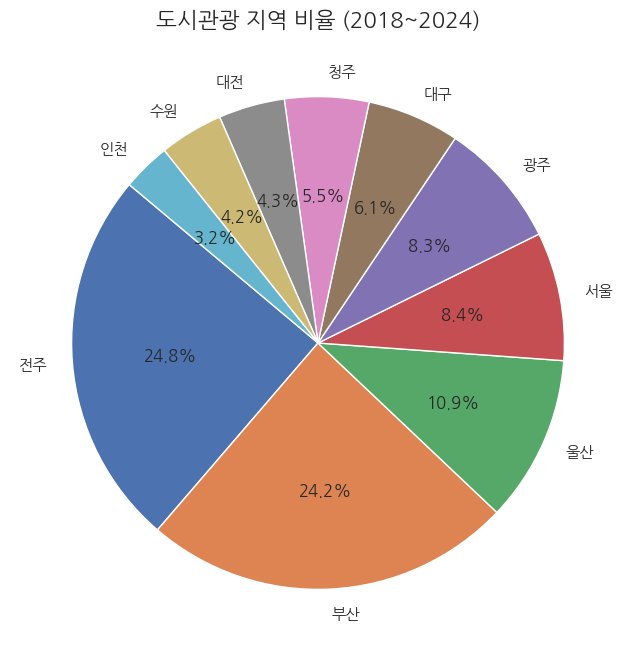

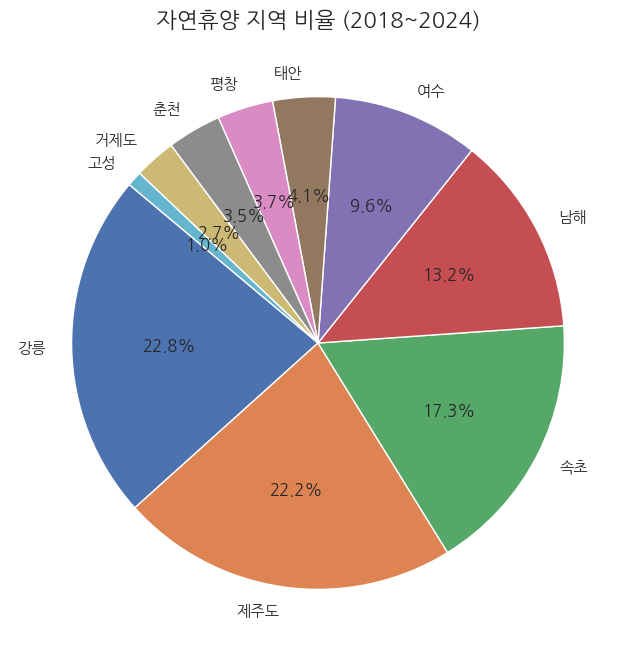

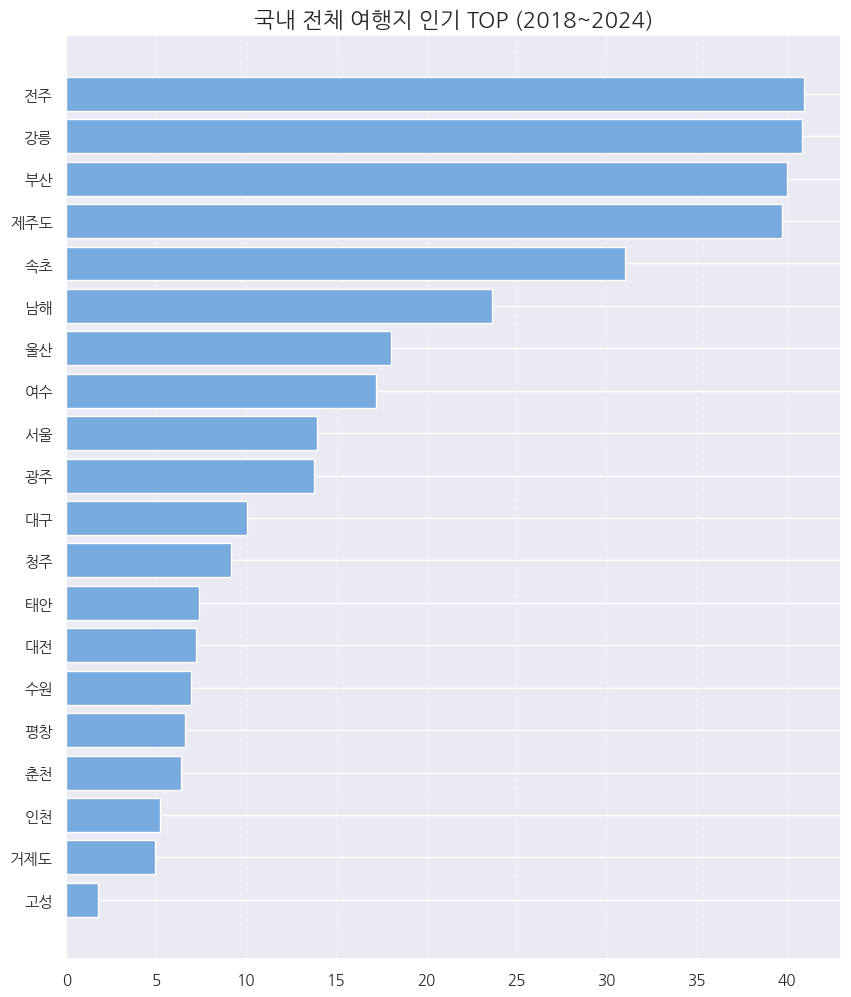

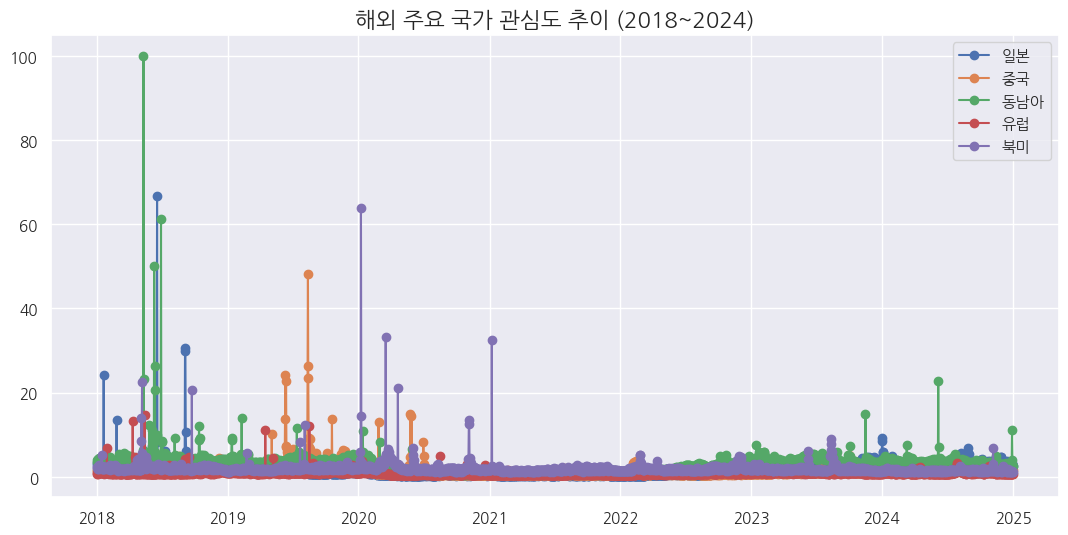

In [34]:

city_mean = df_city_all.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_pie("도시관광 지역 비율 (2018~2024)", city_mean)

nat_mean = df_nat_all.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_pie("자연휴양 지역 비율 (2018~2024)", nat_mean)

domestic_mean = df_domestic_region.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_region_bar(domestic_mean, "국내 전체 여행지 인기 TOP (2018~2024)")

plot_line(df_overseas_region, "date", "ratio", "region",
          "해외 주요 국가 관심도 추이 (2018~2024)")

# 5. 탐색적 데이터 분석 (EDA)

**1) 도시관광·자연휴양 인기 지역 분석**

● 도시관광

* 대구·대전·인천·수원·청주 등 중·대도시 비중 높음
* 계절성 영향 적고 안정적 패턴

● 자연휴양
* 제주도, 강릉, 속초, 태안, 평창 등 선호도 높음
* 여름·가을철 뚜렷한 계절성 상승

**2) 성별 국내여행 규모 변화**

* 남녀 모두 코로나(mid) 구간에서 급락
* 2022~2024 회복세 강함
* 여성의 여행 규모가 지속적으로 높음

**3) 연령대별 변화**

* 20~40대가 핵심층
* 고령층(60대+) 여행수요 post에서 빠르게 증가

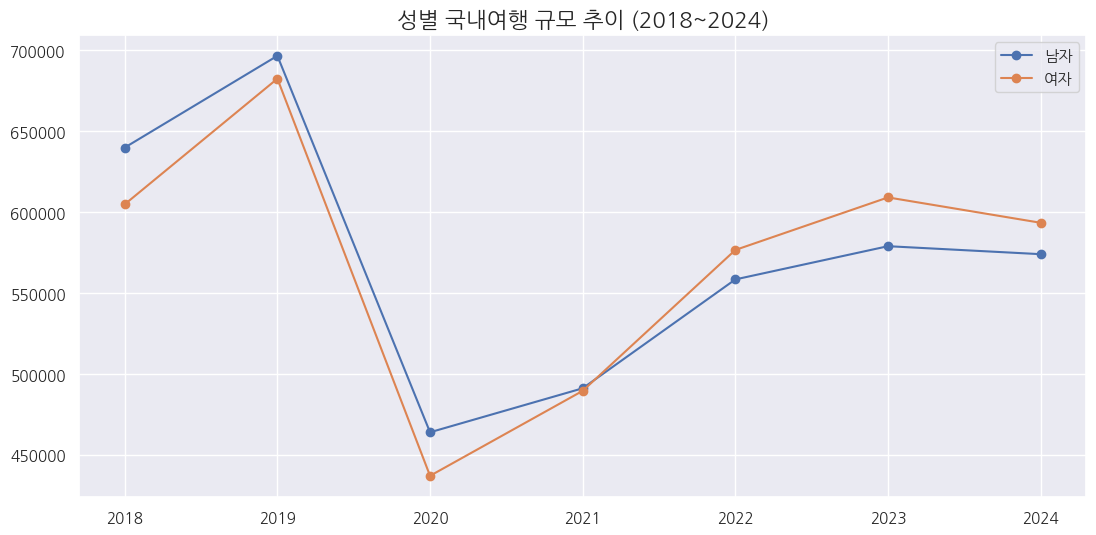

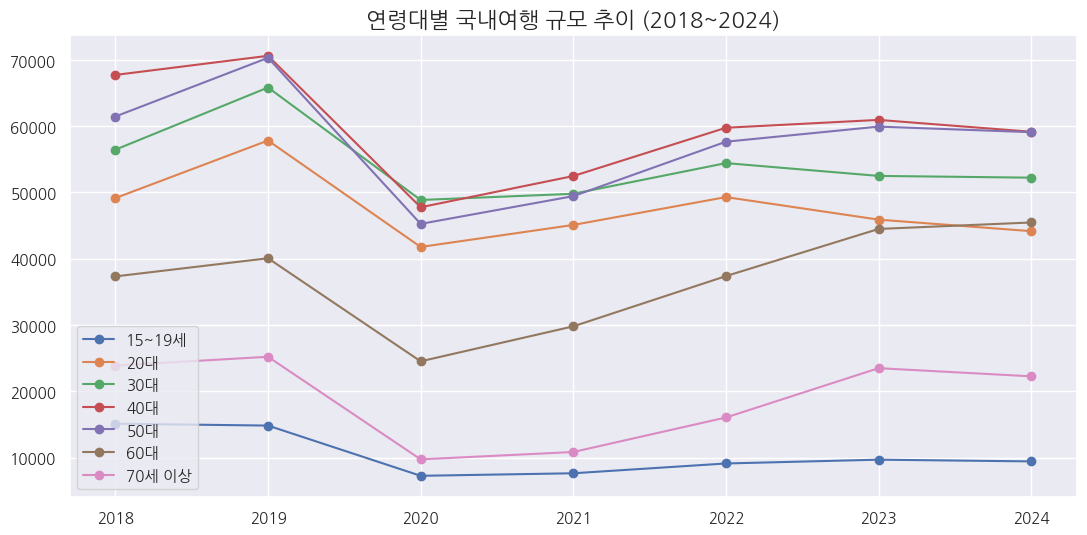

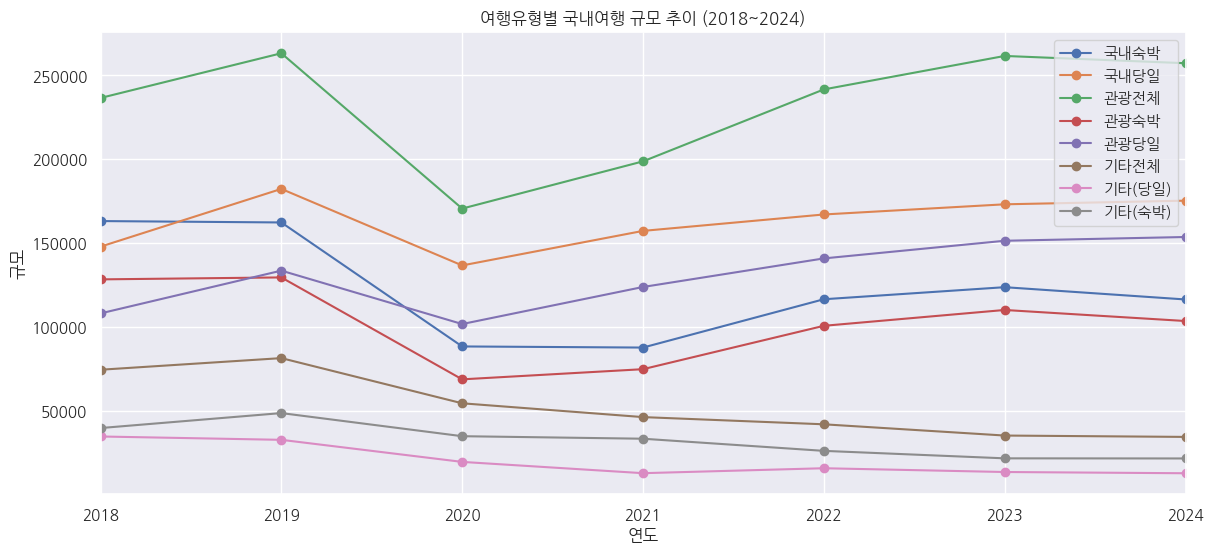

In [35]:

sex_all = df_long[df_long["sub_category"].isin(["남자","여자"])]
sex_year = sex_all.groupby(["sub_category","year"])["value"].sum().reset_index()
plot_line(sex_year, "year", "value", "sub_category",
          "성별 국내여행 규모 추이 (2018~2024)")

age_all = df_long[(df_long["category"]=="연령") & (df_long["type"]=="국내전체")]
plot_line(age_all, "year", "value", "sub_category",
          "연령대별 국내여행 규모 추이 (2018~2024)")

type_all = df_long[df_long["category"] == "전체"]

plt.figure(figsize=(14,6))

for t in type_all["type"].unique():
    if t != "국내전체":
        temp = type_all[type_all["type"] == t]
        plt.plot(temp["year"], temp["value"], marker="o", label=t)

plt.title("여행유형별 국내여행 규모 추이 (2018~2024)")
plt.xlabel("연도")
plt.ylabel("규모")
plt.legend()
plt.grid(True)
plt.xlim(2018, 2024)
plt.show()

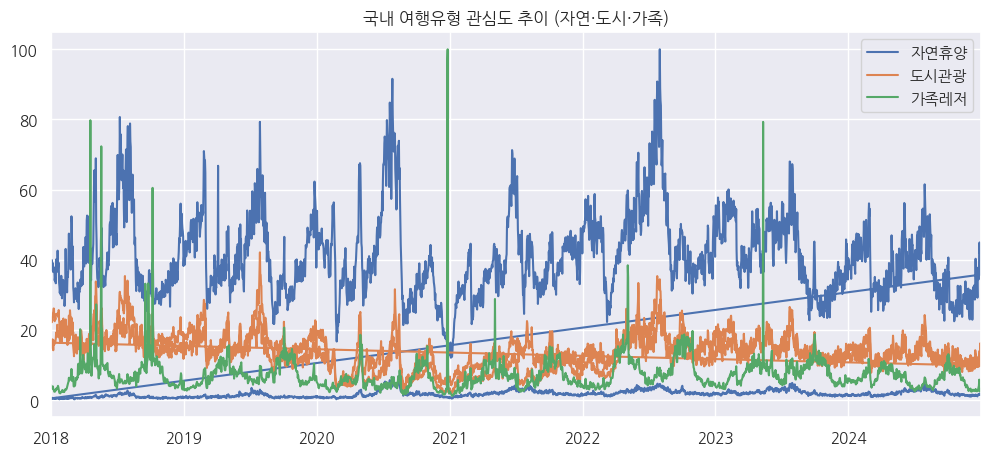

In [36]:

plt.figure(figsize=(12,5))

for c in df_keywords["category"].unique():
    temp = df_keywords[df_keywords["category"] == c]
    plt.plot(temp["date"], temp["ratio"], label=c)

plt.title("국내 여행유형 관심도 추이 (자연·도시·가족)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlim(df_keywords["date"].min(), pd.to_datetime("2024-12-31"))

plt.show()


**4) 여행유형 변화**

* mid: 당일 여행 증가
* post: 숙박 여행 회복 → 이전보다 높은 수준 유지

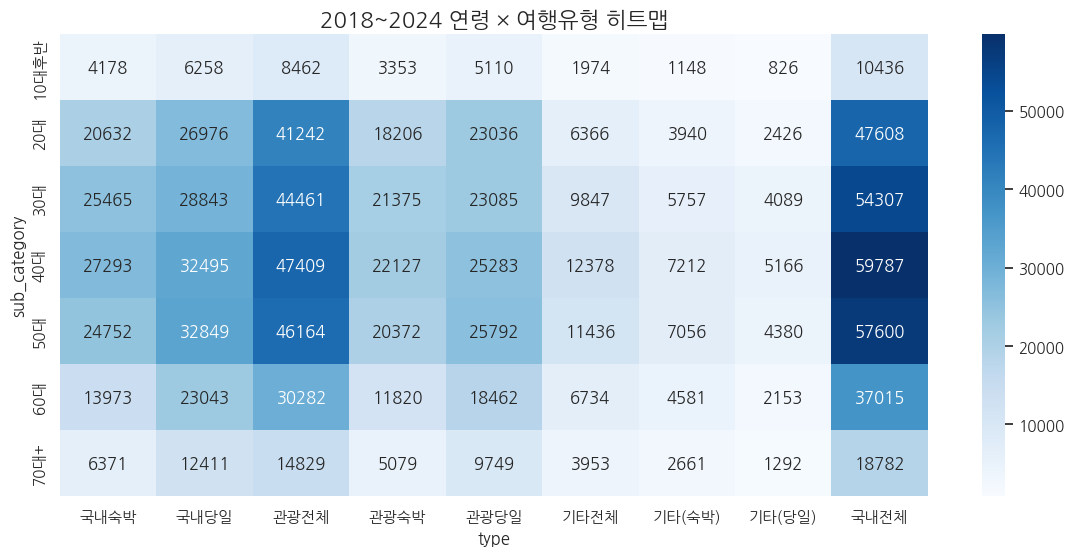

In [37]:

df_total = df_long[df_long["category"]=="연령"].copy()

age_label_map = {
    "15~19": "10대후반", "15~19세":"10대후반",
    "20대":"20대","30대":"30대","40대":"40대",
    "50대":"50대","60대":"60대","70세 이상":"70대+"
}

df_total["sub_category"] = df_total["sub_category"].astype(str).replace(age_label_map)
df_total["value"] = df_total["value"].astype(str).str.replace(",","").str.replace(" ","")
df_total["value"] = pd.to_numeric(df_total["value"], errors="coerce").fillna(0)

type_map = {
    '1': "국내숙박",'2':"국내당일",'3':"관광전체",
    '4': "관광숙박",'5':"관광당일",'6':"기타전체",
    '7': "기타(당일)",'8':"기타(숙박)",'국내전체':"국내전체"
}
df_total["type"] = df_total["type"].astype(str).replace(type_map)

pivot_total = df_total.pivot_table(
    index="sub_category", columns="type", values="value", aggfunc="mean"
)

age_order = ["10대후반","20대","30대","40대","50대","60대","70대+"]
type_order = ["국내숙박","국내당일","관광전체","관광숙박","관광당일",
              "기타전체","기타(숙박)","기타(당일)","국내전체"]

pivot_total = pivot_total.reindex(index=age_order, columns=type_order).fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_total, annot=True, fmt=".0f", cmap="Blues")
plt.title("2018~2024 연령 × 여행유형 히트맵", fontsize=16)
plt.show()


**5) 국내 vs 해외 관심도**

* 해외여행: mid에서 최저 → post에서 폭발적 회복
* 국내여행: mid 시기 최고 → post에서 정상화

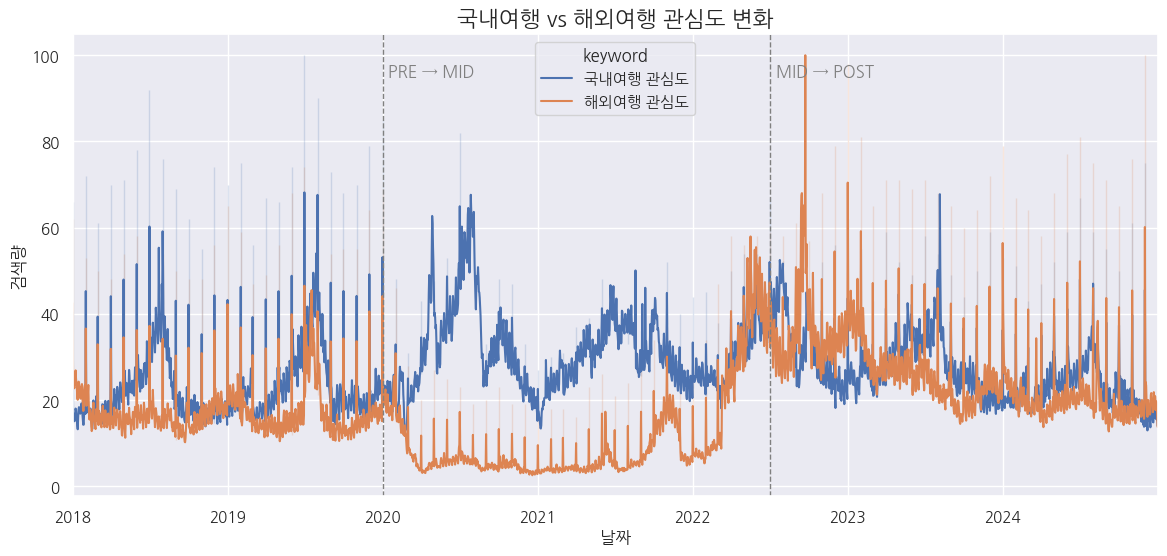

In [38]:

df_plot = df_all[
    (df_all["keyword"].isin(["domestic", "overseas"])) &
    (df_all["source"].isin(["google", "naver"]))
].copy()

df_plot["keyword"] = df_plot["keyword"].replace({
    "domestic": "국내여행 관심도",
    "overseas": "해외여행 관심도"
})

plt.figure(figsize=(14,6))
sns.lineplot(data=df_plot, x="date", y="value", hue="keyword")
plt.title("국내여행 vs 해외여행 관심도 변화", fontsize=16)
plt.xlabel("날짜")
plt.ylabel("검색량")
plt.grid(True)

plt.axvline(pd.to_datetime("2020-01-01"), color="gray", linestyle="--", linewidth=1)
plt.text(pd.to_datetime("2020-01-15"), df_plot["value"].max()*0.95, "PRE → MID", color="gray")

plt.axvline(pd.to_datetime("2022-07-01"), color="gray", linestyle="--", linewidth=1)
plt.text(pd.to_datetime("2022-07-15"), df_plot["value"].max()*0.95, "MID → POST", color="gray")
plt.xlim(df_plot["date"].min(), pd.to_datetime("2024-12-31"))

plt.show()


**6) 코로나 단계별 분석**

* 국내: mid > post > pre
* 해외: post > pre > mid

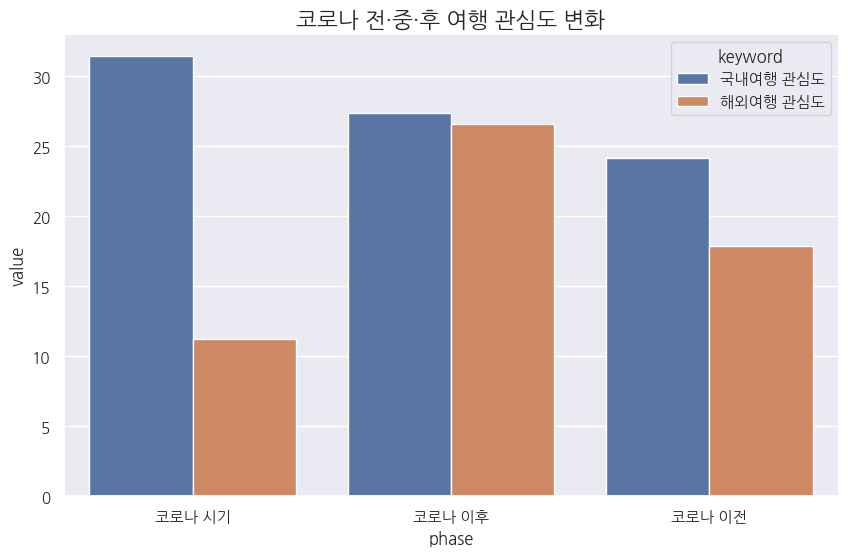

In [39]:

df_phase = df_all[(df_all["keyword"].isin(["domestic","overseas"])) &
                  (df_all["source"].isin(["google","naver"]))].copy()

df_phase["keyword"] = df_phase["keyword"].replace({
    "domestic":"국내여행 관심도",
    "overseas":"해외여행 관심도"
})

df_bar = df_phase.groupby(["phase","keyword"])["value"].mean().reset_index()
df_bar["phase"] = df_bar["phase"].replace({
    "pre":"코로나 이전", "mid":"코로나 시기", "post":"코로나 이후"
})

plt.figure(figsize=(10,6))
sns.barplot(data=df_bar, x="phase", y="value", hue="keyword")
plt.title("코로나 전·중·후 여행 관심도 변화", fontsize=16)
plt.show()


**7) 해외 관심도 vs 출국자수**

→ 높은 상관관계
온라인 관심도 증가 = 실제 출국 증가와 일치

In [40]:

import plotly.express as px

df_compare = df_all[df_all["keyword"].isin(["overseas", "departure"])]
df_clean = df_compare.groupby(["date", "keyword"])["value"].mean().reset_index()
df_s = df_clean.pivot(index="date", columns="keyword", values="value").dropna()

df_s = df_s.rename(columns={
    "overseas": "해외여행 관심도",
    "departure": "출국자수"
})

fig = px.scatter(
    df_s,
    x="해외여행 관심도",
    y="출국자수",
    trendline="ols",
    title="해외여행 관심도 vs 출국자수 상관관계"
)

fig.update_layout(
    font=dict(family="NanumGothic"),
    title_font=dict(size=22),
    xaxis_title_font=dict(size=16),
    yaxis_title_font=dict(size=16)
)

fig.update_traces(
    hovertemplate='관심도: %{x}<br>출국자수: %{y}'
)

fig.show()


# 6. 지역 기반 분석 & 추천
**1) WordCloud**

* 제주·부산·강릉·속초 등이 크게 표현
→ 국내 여행 인기 지역이 집중되어 있음

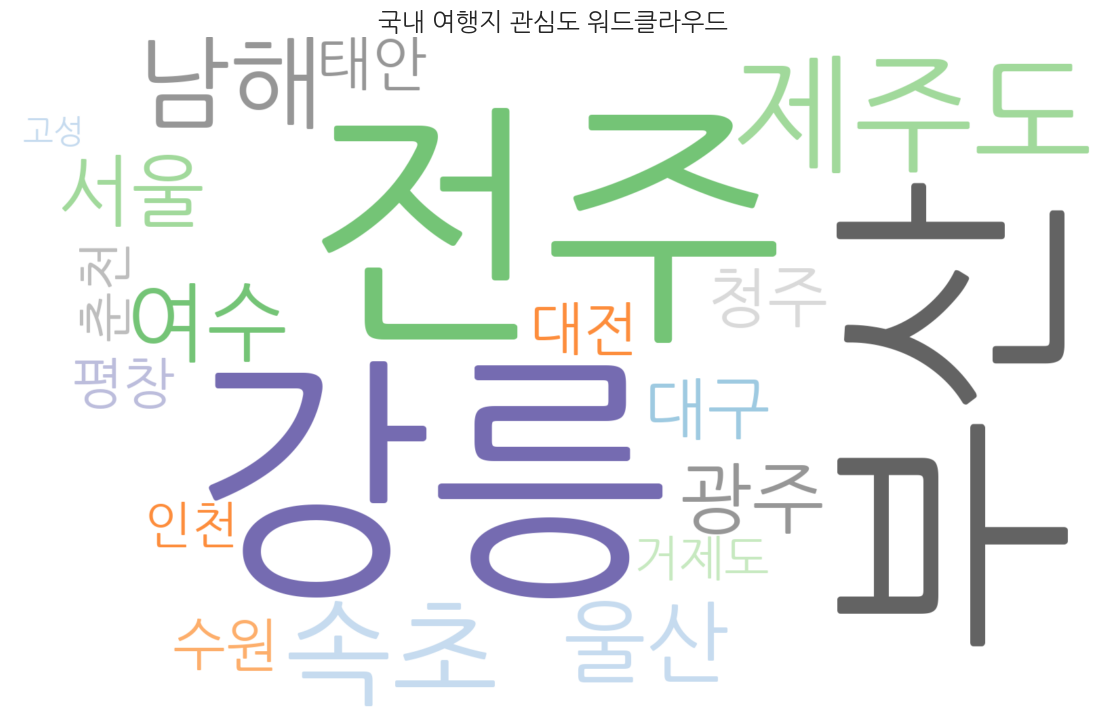

In [42]:

from wordcloud import WordCloud

df_region_all = df_domestic_region.copy()
region_mean = df_region_all.groupby("region")["ratio"].mean()

wc = WordCloud(
    font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    background_color="white",
    colormap="tab20c",
    width=1600, height=1000
).generate_from_frequencies(region_mean.to_dict())

plt.figure(figsize=(14,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("국내 여행지 관심도 워드클라우드", fontsize=18)
plt.show()



**2) Cosine Similarity 추천 결과**

● 인천 → '강릉', '광주', '부산', '춘천', '울산'

● 강릉 →'속초', '인천', '부산', '울산', '여수'

→ 지역 관심도 패턴 기반 자동 추천 가능

In [43]:

from sklearn.metrics.pairwise import cosine_similarity

sim_df = pd.DataFrame(
    cosine_similarity(pivot_region.T),
    index=pivot_region.columns,
    columns=pivot_region.columns
)

def recommend_region(region, top=5):
    sims = sim_df.loc[region].sort_values(ascending=False)
    return sims.index[1:top+1]

print("인천 추천:", recommend_region("인천"))
print("강릉 추천:", recommend_region("강릉"))

인천 추천: Index(['강릉', '광주', '부산', '춘천', '울산'], dtype='object', name='region')
강릉 추천: Index(['속초', '인천', '부산', '울산', '여수'], dtype='object', name='region')


# 7. 머신러닝 분석

**1) KMeans 군집화 결과 (실제 결과 기반 수정본)**

* Cluster 0
거제도, 고성, 대구, 대전, 인천, 수원, 춘천, 청주, 평창, 태안
→ 비교적 중간값 중심, 일정한 계절성

* Cluster 1
남해, 속초
→ 여름 성수기 계절 탄력 큰 지역

* Cluster 2
서울, 부산, 여수, 울산, 광주
→ 대도시·남부권 중심, 비교적 안정적 패턴

* Cluster 3
제주도, 전주, 강릉
→ 지속적으로 높은 관심도 / 고유 패턴

   region  cluster
1     거제도        0
2      고성        0
6      대전        0
5      대구        0
13     인천        0
10     수원        0
17     춘천        0
16     청주        0
19     평창        0
18     태안        0
4      남해        1
9      속초        1
11     여수        2
12     울산        2
3      광주        2
8      서울        2
15    제주도        3
14     전주        3
0      강릉        3
7      부산        3


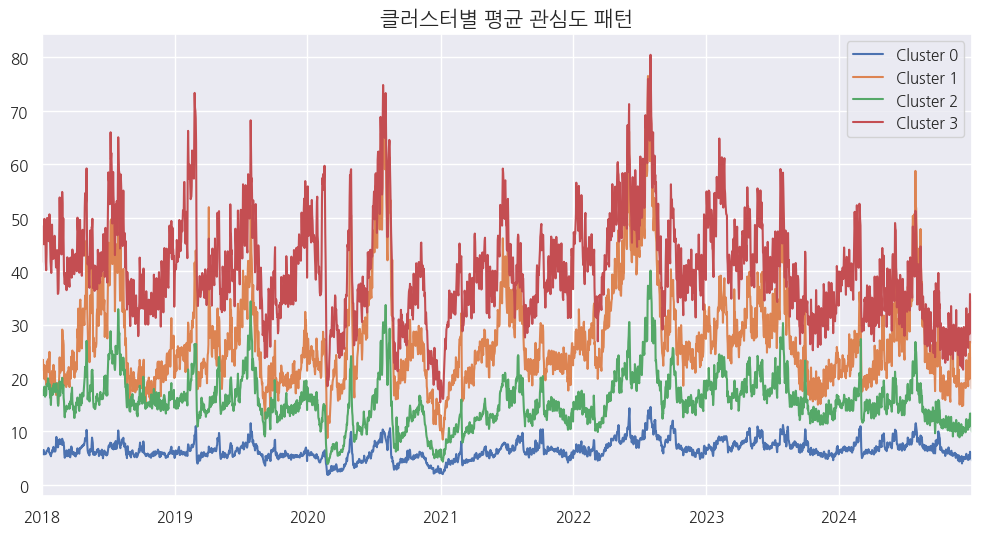

In [44]:

pivot = df_region_all.pivot_table(index="date", columns="region", values="ratio").fillna(0)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(pivot.T)

clusters = pd.DataFrame({"region":pivot.columns, "cluster":labels})
print(clusters.sort_values("cluster"))

plt.figure(figsize=(12,6))
for c in range(4):
    group = clusters[clusters["cluster"]==c]["region"]
    plt.plot(pivot[group].mean(axis=1), label=f"Cluster {c}")
plt.legend()
plt.title("클러스터별 평균 관심도 패턴", fontsize=15)
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2024-12-31"))
plt.show()


**2) PCA 분석 결과**

* PC1: 전체 관심도 수준
* PC2: 계절 변동성
* 도시 지역끼리 군집 형성
* 자연휴양지끼리 군집 형성
* 제주도는 독립된 패턴(가장 큰 계절성 + 높은 관심도)

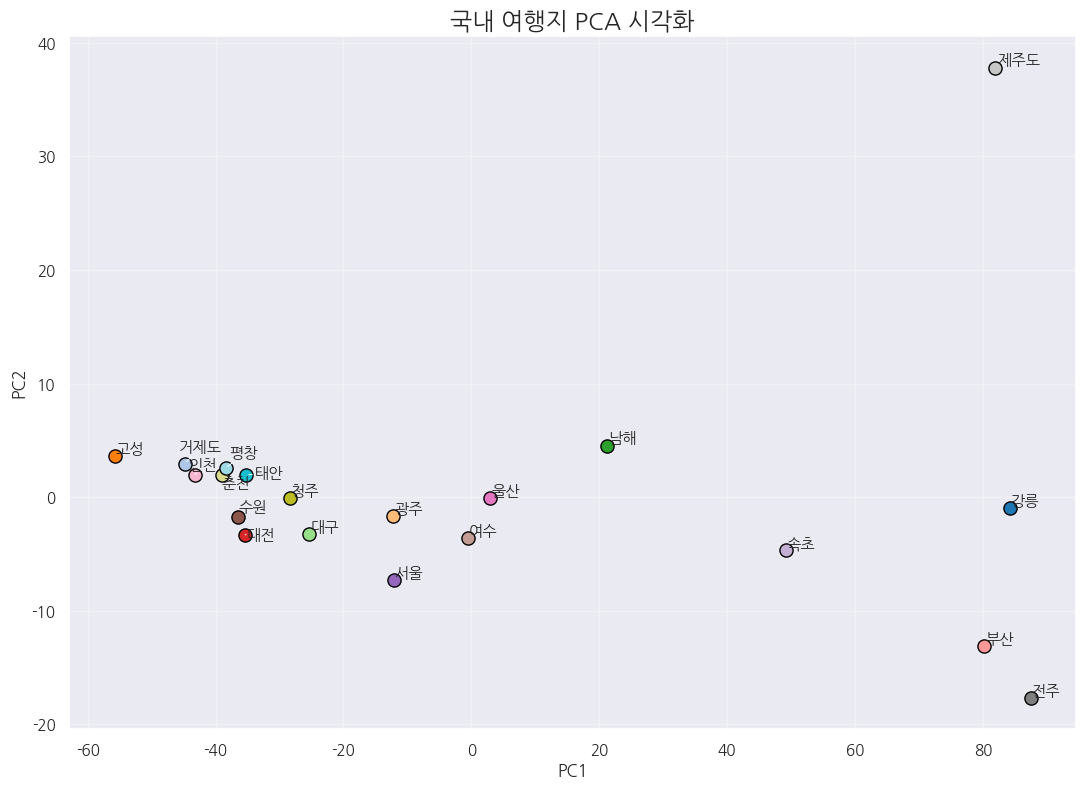

In [45]:

!pip install adjustText

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text

pivot_region = pivot.copy()
X = pivot_region.T

scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

pca_df = pd.DataFrame({
    "region": X.index,
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1]
})

plt.figure(figsize=(13,9))
colors = plt.cm.tab20.colors
texts = []

for i in range(len(pca_df)):
    plt.scatter(pca_df["PC1"][i], pca_df["PC2"][i],
                s=90, color=colors[i%20], edgecolor='black')
    texts.append(
        plt.text(pca_df["PC1"][i], pca_df["PC2"][i],
                 pca_df["region"][i], fontsize=11)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', lw=0.7))
plt.title("국내 여행지 PCA 시각화", fontsize=17)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


# 8. 2025 여행 관심도 예측 (Prophet)

● 국내여행

* 완만한 증가
* 계절성(여름·겨울) 유지

● 해외여행

* 2024 대비 높은 증가세
* post 구간의 회복세가 이어질 가능성 매우 높음

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


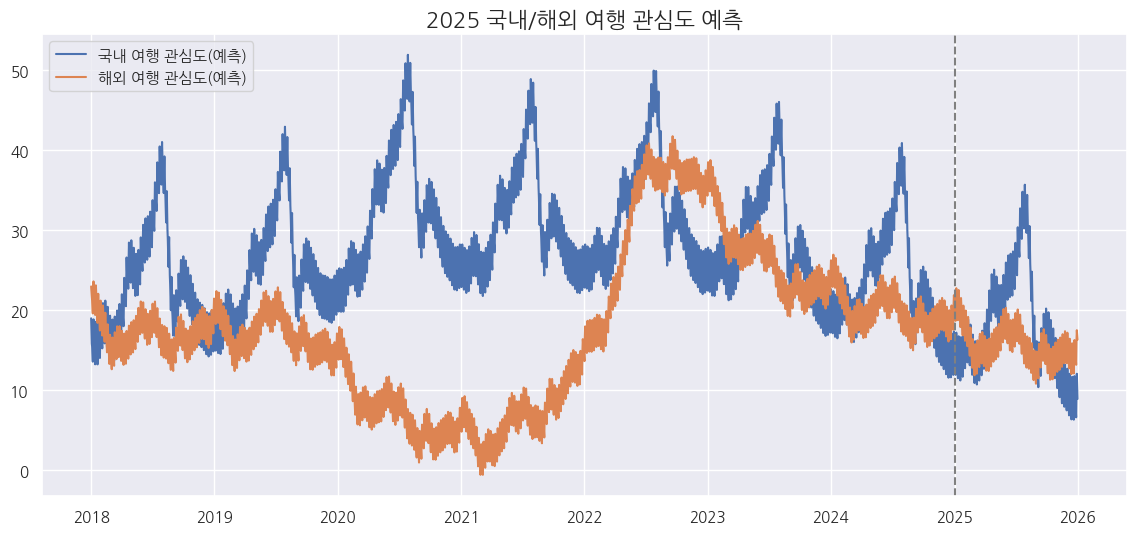

In [46]:

from prophet import Prophet

def forecast_prophet(df, periods=365):
    m = Prophet(yearly_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=periods)
    fc = m.predict(future)
    return m, fc

dom_ts = df_all[df_all["keyword"]=="domestic"].groupby("date")["value"].mean().reset_index()
dom_ts = dom_ts.rename(columns={"date":"ds","value":"y"})

over_ts = df_all[df_all["keyword"]=="overseas"].groupby("date")["value"].mean().reset_index()
over_ts = over_ts.rename(columns={"date":"ds","value":"y"})

model_dom, fc_dom = forecast_prophet(dom_ts)
model_over, fc_over = forecast_prophet(over_ts)

plt.figure(figsize=(14,6))
plt.plot(fc_dom["ds"], fc_dom["yhat"], label="국내 여행 관심도(예측)")
plt.plot(fc_over["ds"], fc_over["yhat"], label="해외 여행 관심도(예측)")
plt.axvline(pd.to_datetime("2025-01-01"), color="gray", linestyle="--")
plt.title("2025 국내/해외 여행 관심도 예측", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# 9. 결론

본 프로젝트는 국내·해외 여행 데이터를 통합하여 다음과 같은 결론을 도출하였다.

1. 코로나19 시기(mid)에 국내여행
관심도가 크게 증가하고,
post에서는 해외여행이 폭발적으로 증가했다.
2. 여행 수요 핵심층은 20~40대이며, 고령층 수요도 증가하고 있다.
3. 여행유형은 코로나 이후 숙박 중심 구조로 회귀했다.
4. 지역별 관심도 패턴이 뚜렷하게 구분되며
추천 시스템을 통해 유사 지역 추천이 가능함을 확인했다.
5. Prophet 예측 결과 2025년 해외여행 수요 증가가 높은 확률로 예상된다.